In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sklearn 

In [58]:
data = yf.download('SPY', start='2022-01-01', end='2023-12-31')
data["ritorni"] = data["Adj Close"].pct_change()
data["trend"] = np.where(data["ritorni"] > 0, 1, 0)
data["target"] = data["Close"].shift(-1)
data.reset_index(inplace=True)
data.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [59]:
from sklearn.model_selection import train_test_split

X = data.index.values
y = data["target"].values

X_train = X[:-2].reshape(-1, 1)
X_test = X[-2:].reshape(-1, 1)
y_train = y[:-2].reshape(-1, 1)
y_test = y[-2:].reshape(-1, 1)

In [60]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

In [61]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

In [62]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

In [63]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [64]:
kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)


In [65]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y_train.mean()
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)

y_pred, y_std = gaussian_process.predict(X_test, return_std=True)
y_pred += y_mean

/Users/letizialibrobuono/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


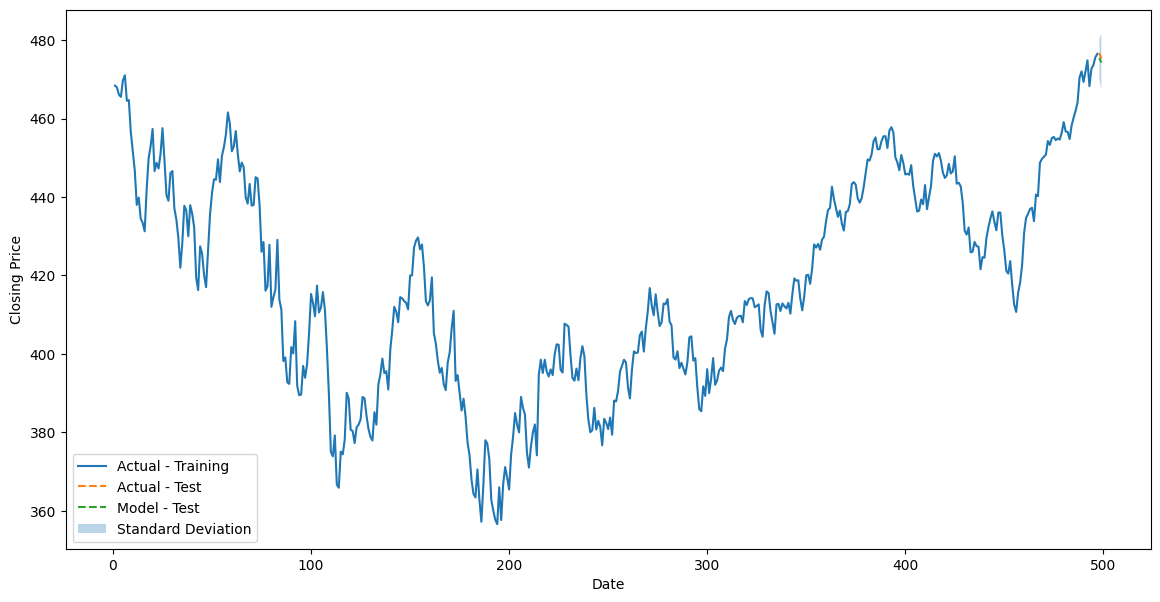

In [66]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data.index[:len(y_train)], y_train, label='Actual - Training')
ax.plot(data.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Actual - Test', linestyle='--')
ax.plot(data.index[len(y_train):len(y_train) + len(y_test)], y_pred, label='Model - Test', linestyle='--')
ax.fill_between(data.index[len(y_train):len(y_train) + len(y_test)], y_pred - y_std, y_pred + y_std, alpha=0.3, label='Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.3154506396821593


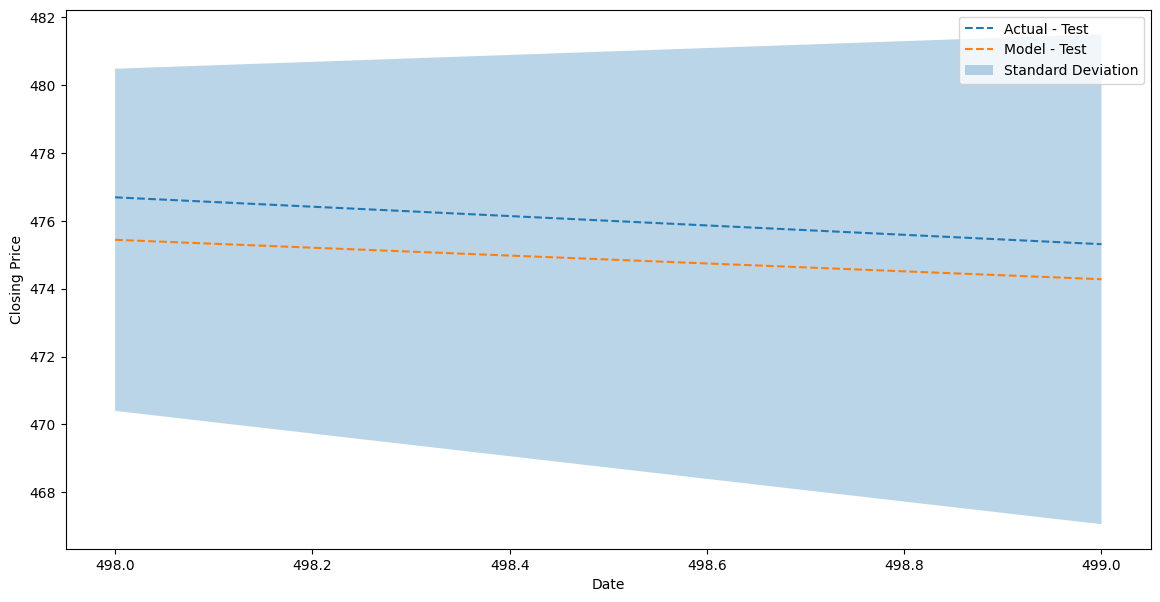

In [68]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data.index[len(y_train):len(y_train) + len(y_test)], y_test, label='Actual - Test', linestyle='--')
ax.plot(data.index[len(y_train):len(y_train) + len(y_test)], y_pred, label='Model - Test', linestyle='--')
ax.fill_between(data.index[len(y_train):len(y_train) + len(y_test)], y_pred - y_std, y_pred + y_std, alpha=0.3, label='Standard Deviation')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.legend()
plt.show()